In [1]:
# 비지도 학습 : 차원 축소와 분류
# 학습 순서 : 스케일 조정, 이상치 제거 -> 차원 축소를 통한 특성 추출 -> 
# 군집 (병합 군집 이용) -> 훈련 데이터와 검증 데이터를 이용하여 학습 
# -> 테스트 데이터로 돌려서 macro f1-score 확인하기.

# 1. 패키지 불러오기

In [2]:
# 패키지 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy import stats
import time

# 경고창 무시하기
import warnings
warnings.filterwarnings('ignore')

# 모든 열 확인하기
pd.set_option('display.max_columns', None)

# 전처리 패키지 불러오기
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

# PCA
from sklearn.decomposition import PCA

# Kmeans
from sklearn.cluster import KMeans

# model
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import MeanShift, estimate_bandwidth

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier

# grid search
from sklearn.model_selection import GridSearchCV

# evaluation
from sklearn.metrics.cluster import silhouette_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn import metrics
from sklearn.metrics import *

# 2. 데이터 불러오기

In [3]:
train=pd.read_csv("./dataset/train_data.csv")
test=pd.read_csv("./dataset/test_data.csv")
answer=pd.read_csv("./dataset/answer_sample.csv")

In [4]:
# 원본 데이터 변형없이 유지하기 위하여 복제하기
train_copy=train.copy()
test_copy=test.copy()

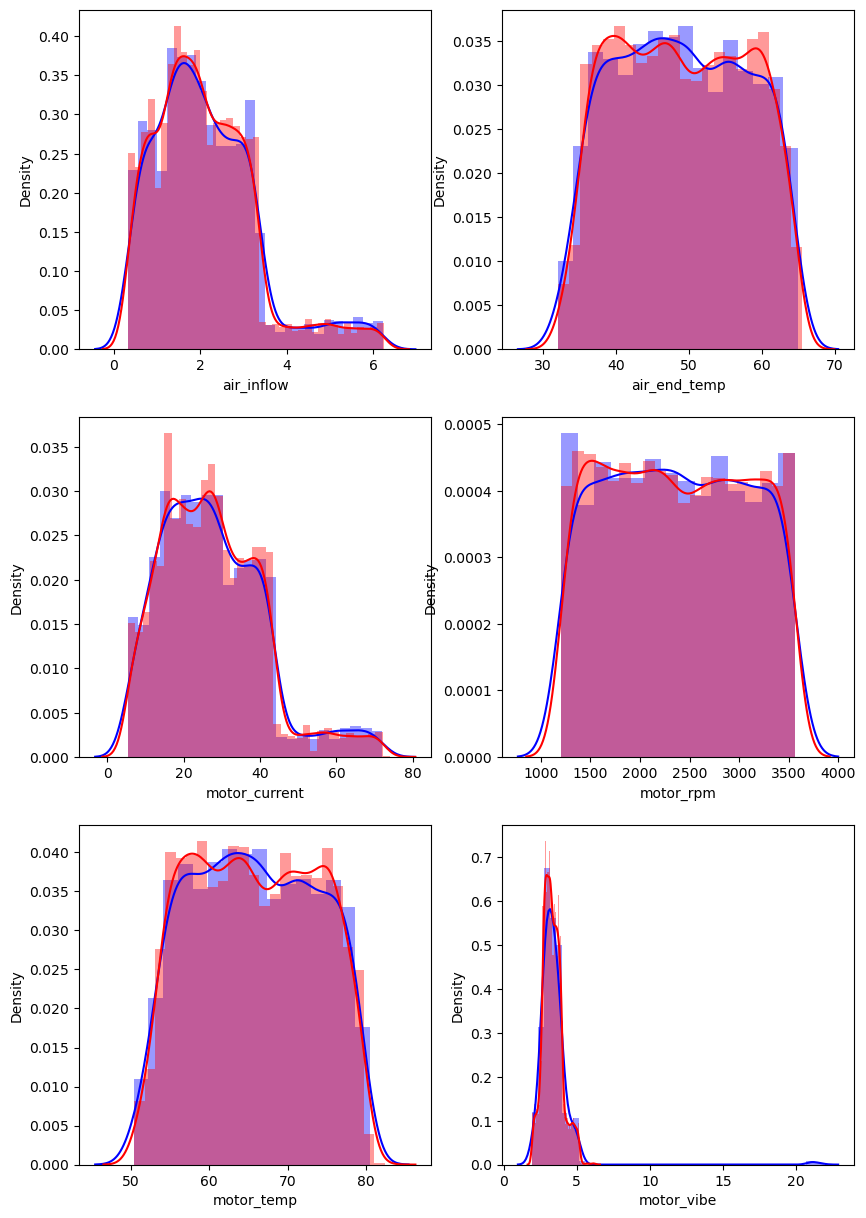

In [5]:
fig, ax=plt.subplots(3, 2, figsize=(10, 15))
ax=ax.flatten()

# 공기 흡입 유량
_=sns.distplot(train_copy["air_inflow"], kde=True, ax=ax[0], color="blue")
_=sns.distplot(test_copy["air_inflow"], kde=True, ax=ax[0], color="red")

# 공기 말단 온도
_=sns.distplot(train_copy["air_end_temp"], kde=True, ax=ax[1], color="blue")
_=sns.distplot(test_copy["air_end_temp"], kde=True, ax=ax[1], color="red")

# 모터 전류
_=sns.distplot(train_copy["motor_current"], kde=True, ax=ax[2], color="blue")
_=sns.distplot(test_copy["motor_current"], kde=True, ax=ax[2], color="red")

# 모터 회전수
_=sns.distplot(train_copy["motor_rpm"], kde=True, ax=ax[3], color="blue")
_=sns.distplot(test_copy["motor_rpm"], kde=True, ax=ax[3], color="red")

# 모터 온도
_=sns.distplot(train_copy["motor_temp"], kde=True, ax=ax[4], color="blue")
_=sns.distplot(test_copy["motor_temp"], kde=True, ax=ax[4], color="red")

# 모터 진동
_=sns.distplot(train_copy["motor_vibe"], kde=True, ax=ax[5], color="blue")
_=sns.distplot(test_copy["motor_vibe"], kde=True, ax=ax[5], color="red")

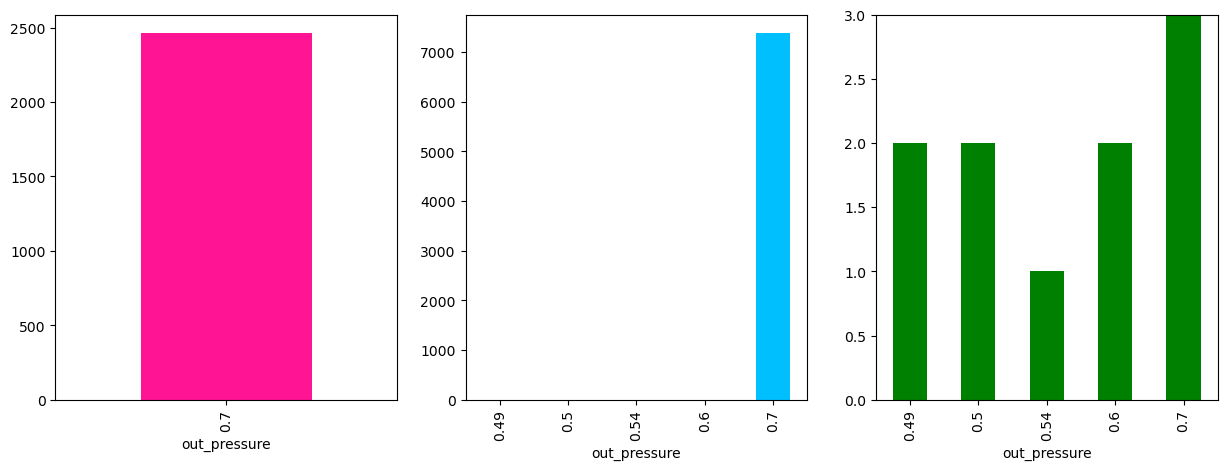

In [6]:
# 토출 압력
# 테스트에는 토출 압력이 5가지가 존재하나, 압도적으로 0.7이 제일 많다.
fig, ax=plt.subplots(1, 3, figsize=(15, 5))
ax=ax.flatten()

_=train_copy.groupby(["out_pressure"]).size().plot.bar(ax=ax[0], color="deeppink")
_=test_copy.groupby(["out_pressure"]).size().plot.bar(ax=ax[1], color="deepskyblue")
_=test_copy.groupby(["out_pressure"]).size().plot.bar(ax=ax[2], color="green")
_=ax[2].set_ylim(0, 3)

In [7]:
train_copy.groupby(["out_pressure"]).size()

out_pressure
0.7    2463
dtype: int64

In [8]:
test_copy.groupby(["out_pressure"]).size()
# 테스트에는 토출 압력이 5가지가 존재하나, 압도적으로 0.7이 제일 많다.

out_pressure
0.49       2
0.50       2
0.54       1
0.60       2
0.70    7382
dtype: int64

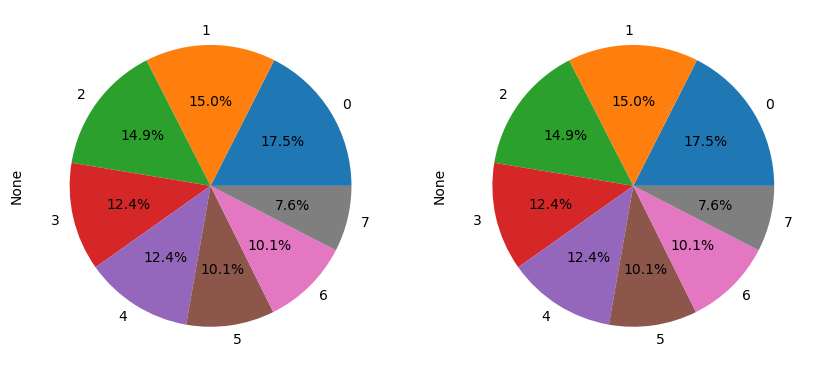

In [9]:
# 설비 번호
# 훈련 데이터와 테스트 데이터 비율이 동일하다.
fig, ax=plt.subplots(1, 2, figsize=(10, 5))
ax=ax.flatten()

_=train_copy.groupby(["type"]).size().plot.pie(ax=ax[0], autopct="%.1f%%")
_=test_copy.groupby(["type"]).size().plot.pie(ax=ax[1], autopct="%.1f%%")

# 3. 스케일 조정 및 이상치 제거하기

* 가우시안 분포를 따르는 경우 : StandardScaler
* 가우시안 분포를 따르지 않는 경우 : MinMaxScaler

1. 공기 흡입 유량, 설비 번호 : 정규성 X & StandardScaler
2. 공기 말단 온도, 토출 압력, 모터 전류, 모터 회전수, 모터 온도, 모터 진동 : 정규성 O & MinMaxScaler
3. 모터 진동에서 이상치가 보인다. 그리고 정규화 진행해야 한다.

In [10]:
# 로그 변환 이용하여 정규화 진행하기.
train_copy["motor_vibe"]=np.log(train_copy["motor_vibe"])

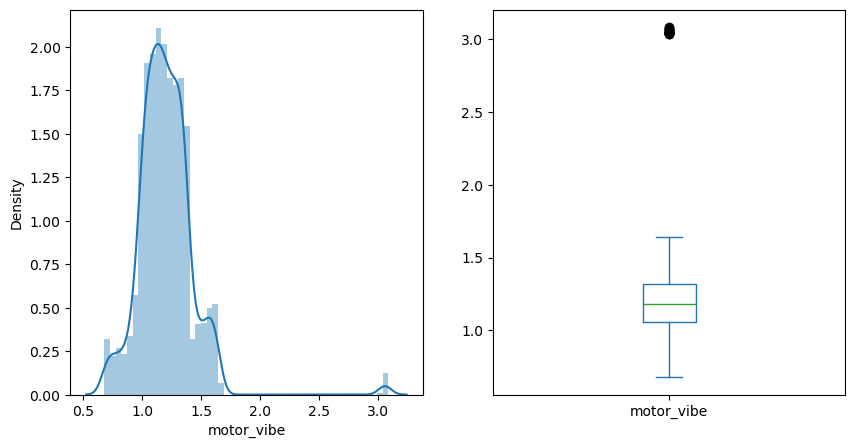

In [11]:
fig, ax=plt.subplots(1, 2, figsize=(10, 5))
ax=ax.flatten()

_=sns.distplot(train_copy["motor_vibe"], ax=ax[0])
_=train_copy["motor_vibe"].plot.box(ax=ax[1])

In [12]:
# 이상치 3 이상부터 이상치라고 보면 된다. 그러면 이상치 대신에 어떤 값 넣어주지?
# 이상치 처리 아직 못 함.

In [13]:
train_copy.groupby(["motor_vibe"]).size().iloc[-15:]

motor_vibe
1.644805    1
3.036394    1
3.038313    1
3.041184    2
3.044522    1
3.045950    1
3.047850    1
3.052113    1
3.054001    1
3.055886    2
3.062924    1
3.068518    1
3.072230    1
3.076851    1
3.085116    1
dtype: int64

In [14]:
# 따로 따로 전처리 후 병합할 예정이다.
# 일단 type은 제거하고 진행하기.
train_preprocess_rs=train_copy[["air_inflow"]]
train_preprocess_rs.head()

,air_inflow
0,1.59
1,2.97
2,1.91
3,2.37
4,1.90


In [15]:
train_preprocess_ms=train_copy.drop(["air_inflow", "type"], axis=1)
train_preprocess_ms.head()

,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe
0,41.00,0.7,20.53,1680.0,58.67,1.075002
1,59.28,0.7,38.40,3142.0,74.91,1.321756
2,45.29,0.7,24.73,2023.0,62.48,1.137833
3,51.33,0.7,30.63,2506.0,67.84,1.220830
4,45.21,0.7,24.65,2017.0,62.41,1.137833


In [16]:
# StandardScaler
scaler=RobustScaler()
scaler.fit(train_preprocess_rs)
rs_scaled=scaler.transform(train_preprocess_rs)
df_rs_scaled=pd.DataFrame(rs_scaled, columns=["air_inflow"])

In [17]:
df_rs_scaled.head()

,air_inflow
0,-0.240260
1,0.655844
2,-0.032468
3,0.266234
4,-0.038961


In [18]:
print(df_rs_scaled.mean()) # 0에 가까운 평균
print(df_rs_scaled.var()) # 1에 가까운 분산

air_inflow    0.109638
dtype: float64
air_inflow    0.609543
dtype: float64


In [19]:
# MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(train_preprocess_ms)
mm_scaled=scaler.transform(train_preprocess_ms)
df_mm_scaled=pd.DataFrame(mm_scaled, columns=list(train_preprocess_ms.columns))

In [20]:
df_mm_scaled.head()

,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe
0,0.272396,0.0,0.227873,0.202708,0.275531,0.164917
1,0.827513,0.0,0.495950,0.821413,0.813992,0.267428
2,0.402672,0.0,0.290879,0.347863,0.401857,0.191019
3,0.586092,0.0,0.379388,0.552264,0.579576,0.225500
4,0.400243,0.0,0.289679,0.345324,0.399536,0.191019


In [21]:
print(df_mm_scaled.min()) # 평균 0
print(df_mm_scaled.max()) # 분산 1
# 그런데 토출 압력 분산은 왜 0이 나오지?

air_end_temp     0.0
out_pressure     0.0
motor_current    0.0
motor_rpm        0.0
motor_temp       0.0
motor_vibe       0.0
dtype: float64
air_end_temp     1.0
out_pressure     0.0
motor_current    1.0
motor_rpm        1.0
motor_temp       1.0
motor_vibe       1.0
dtype: float64


In [22]:
df_type=train_copy["type"].to_frame()
df_type.head()

,type
0,0
1,0
2,0
3,0
4,0


In [23]:
# 병합하기
train_copy=pd.concat([df_rs_scaled, df_mm_scaled, df_type], axis=1)
train_copy.head() # 전처리 끝낸 훈련 데이터 프레임

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
0,-0.240260,0.272396,0.0,0.227873,0.202708,0.275531,0.164917,0
1,0.655844,0.827513,0.0,0.495950,0.821413,0.813992,0.267428,0
2,-0.032468,0.402672,0.0,0.290879,0.347863,0.401857,0.191019,0
3,0.266234,0.586092,0.0,0.379388,0.552264,0.579576,0.225500,0
4,-0.038961,0.400243,0.0,0.289679,0.345324,0.399536,0.191019,0


# 4. 차원 축소를 통한 특성 추출하기

In [24]:
# 주성분 분석 이용해보기.
# 8개 모두 이용한 경우

pca=PCA()
pca.fit(train_copy)

print("\n Eigenvectors: \n", pca.components_)
print("\n Eigenvalues: \n",pca.explained_variance_)


 Eigenvectors: 
 [[ 6.83089275e-02  6.23107763e-03  0.00000000e+00  1.69768027e-02
   9.34393820e-05  6.85246854e-03  2.93582380e-03  9.97472440e-01]
 [ 8.75518246e-01  2.36482304e-01 -0.00000000e+00  2.31925295e-01
   2.37182833e-01  2.36133974e-01  8.49325288e-02 -6.72762565e-02]
 [-4.07829156e-01  4.95184069e-01  3.33066907e-16 -5.38659652e-02
   6.06701309e-01  4.65804030e-01  8.76345373e-04  2.24929961e-02]
 [-8.06818190e-02  7.41168336e-03  2.77555756e-17 -7.45489161e-03
  -8.02328649e-02  2.31298369e-02  9.93177339e-01  2.53127068e-03]
 [ 1.10480702e-01 -4.27749195e-01  1.24900090e-15 -3.13937175e-01
   7.21146031e-01 -4.24419357e-01  7.79441411e-02  3.06803083e-03]
 [ 2.07029799e-01  1.01455010e-01 -2.33146835e-15 -9.13655801e-01
  -2.18878629e-01  2.52910061e-01 -1.43662916e-02 -9.35998613e-04]
 [ 3.00032023e-02  7.10994097e-01 -5.39152056e-15 -9.81929475e-02
  -3.55112926e-02 -6.94687064e-01  9.70426362e-03 -7.77909227e-05]
 [ 5.89414951e-16  4.62850697e-15  1.00000000e+00 -

In [25]:
B = pca.transform(train_copy)

print("\n Projected Data: \n", B)


 Projected Data: 
 [[-2.97887259e+00 -3.18499660e-01 -3.25982701e-01 ...  6.46208610e-03
   6.03181183e-04  7.50421726e-16]
 [-2.90560207e+00  9.42106601e-01  1.95281385e-01 ...  2.66007949e-03
   8.12282336e-04  8.10622209e-16]
 [-2.96184127e+00 -2.46779754e-02 -2.02677988e-01 ...  4.93535842e-03
   6.18012962e-04  7.62849864e-16]
 ...
 [ 3.98220790e+00 -1.15428129e+00 -3.17947354e-01 ...  6.19741084e-04
   6.14824122e-05 -1.01942098e-15]
 [ 3.98326549e+00 -1.13613491e+00 -3.10590786e-01 ...  6.44380064e-04
   9.81885525e-05 -1.01836546e-15]
 [ 4.06345222e+00  2.43547797e-01  2.59421033e-01 ... -3.52130850e-03
   1.36226376e-04 -9.54182291e-16]]


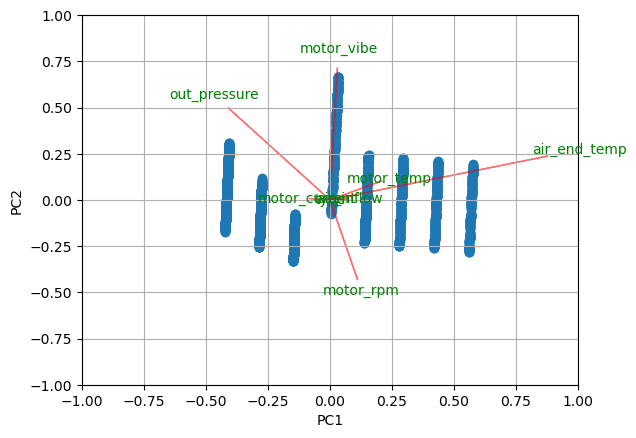

In [26]:
def biplot(score,coeff,pcax,pcay,labels=None):
    pca1=pcax-1
    pca2=pcay-1
    xs = score[:,pca1]
    ys = score[:,pca2]
    n=score.shape[1]
    scalex = 1.0/(xs.max()- xs.min())
    scaley = 1.0/(ys.max()- ys.min())
    plt.scatter(xs*scalex,ys*scaley)
    # 산점도 찍힌 모습이 이상한데..
    for i in range(n):
        plt.arrow(0, 0, coeff[i,pca1], coeff[i,pca2],color='r',alpha=0.5)
        if labels is None:
            plt.text(coeff[i,pca1]* 1.15, coeff[i,pca2] * 1.15, "Var"+str(i+1), color='g', ha='center', va='center')
        else:
            plt.text(coeff[i,pca1]* 1.15, coeff[i,pca2] * 1.15, labels[i], color='g', ha='center', va='center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(pcax))
    plt.ylabel("PC{}".format(pcay))
    plt.grid()
    
biplot(B, pca.components_, 1, 2, labels=train_copy.columns)

*  각 PC축에 가깝게 평행을 이루는 변수가 해당 PC에 영향을 가장 많이 주는 변수 : PC2에 모터 진동이 가장 큰 영향을 준다. 그리고 PC2 보다는 적지만, PC1에 공기 말단 온도가 가장 큰 영향을 준다.
* 각 빨간선의 길이는 원변수의 분산을 표현, 길이가 길수록 분산이 긺 : 공기 말단 온도가 가장 분산이 길다.
* 각 빨간선이 가까울수록 서로 상관관계가 있다. (반대로 서로 거리가 멀수록 상관관계가 적다.) : 모터 온도와 공기 말단 온도가 서로 상관관계를 갖는다.
* 주의 : 변수의 개수를 다르게 지정하면 결과와 해석이 아예 달라질 수 있다.

In [27]:
# 주성분 개수 지정하기.
# 1. 고유값
# 2. 누적 기여율
# 3. scree plot

In [28]:
pca=PCA(n_components=8)
pca_array=pca.fit_transform(train_copy)
pca_df=pd.DataFrame(pca_array, columns=[f"pca{num+1}" for num in range(8)])

pca_df.head()

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8
0,-2.978873,-0.318500,-0.325983,-0.013214,-0.026515,0.006462,0.000603,-2.168988e-18
1,-2.905602,0.942107,0.195281,-0.018771,-0.023490,0.002660,0.000812,2.543049e-18
2,-2.961841,-0.024678,-0.202678,-0.012283,-0.025967,0.004935,0.000618,3.937684e-16
3,-2.937454,0.394118,-0.031616,-0.013727,-0.024547,0.004230,0.000916,-6.641689e-19
4,-2.962336,-0.032366,-0.203790,-0.011618,-0.026115,0.004410,0.000516,-7.105279e-19


In [29]:
result=pd.DataFrame({"설명가능한 분산 비율(고유값)" : pca.explained_variance_, 
                   "기여율" : pca.explained_variance_ratio_},
                   index=np.array([f"pca{num+1}" for num in range(8)]))
result["누적기여율"]=result["기여율"].cumsum()
result

# 누적기여율이 80% 넘어가는 지점까지 주성분을 기준으로 주성분의 개수 정하기.
# 주성분의 개수 : 1개라고 지정하기.

,설명가능한 분산 비율(고유값),기여율,누적기여율
pca1,4.995219e+00,8.529197e-01,0.852920
pca2,7.394401e-01,1.262573e-01,0.979177
pca3,1.165804e-01,1.990577e-02,0.999083
pca4,4.919356e-03,8.399663e-04,0.999923
pca5,3.746765e-04,6.397496e-05,0.999987
pca6,7.584339e-05,1.295005e-05,1.000000
pca7,1.709761e-06,2.919369e-07,1.000000
pca8,6.309832e-35,1.077386e-35,1.000000


In [30]:
# 주성분의 개수 : 2개라고 지정하였을 경우
pca=PCA(n_components=2)
pca.fit(train_copy)
data2 = pd.DataFrame(data = pca.transform(train_copy), columns=['pc1', 'pc2'])

In [31]:
data2.head()

,pc1,pc2
0,-2.978873,-0.318500
1,-2.905602,0.942107
2,-2.961841,-0.024678
3,-2.937454,0.394118
4,-2.962336,-0.032366


In [32]:
x = []   # k 가 몇개인지 
y = []   # 응집도가 몇인지 

for k in range(1, 30):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(data2)
    
    x.append(k)
    y.append(kmeans.inertia_)

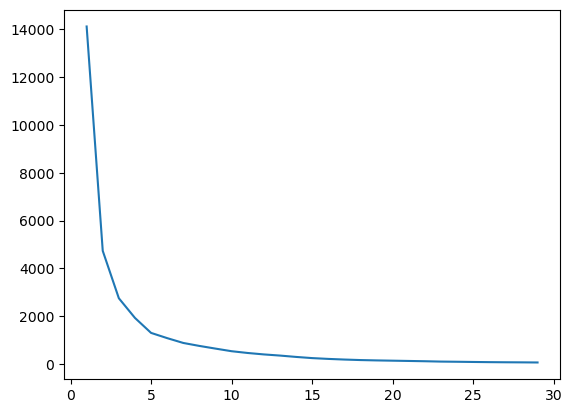

In [33]:
_=plt.plot(x, y)

In [34]:
x = []   # k 가 몇개인지 
y = []   # 응집도가 몇인지 

for k in range(1, 5):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(data2)
    
    x.append(k)
    y.append(kmeans.inertia_)

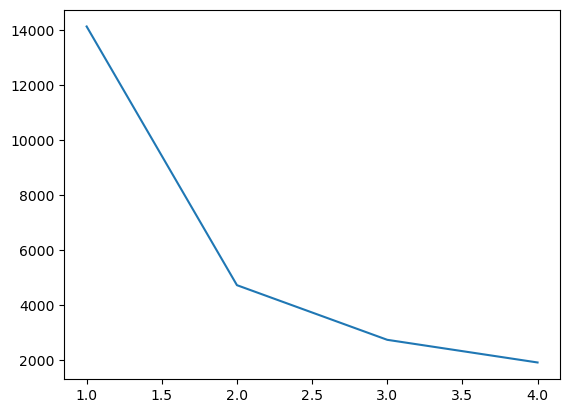

In [35]:
_=plt.plot(x, y)

# 5. 군집화

In [36]:
kmeans = KMeans(n_clusters=2)

In [37]:
kmeans.fit(data2)

KMeans(n_clusters=2)

In [38]:
data2['labels'] = kmeans.predict(data2)

In [39]:
data2.head()

,pc1,pc2,labels
0,-2.978873,-0.318500,0
1,-2.905602,0.942107,0
2,-2.961841,-0.024678,0
3,-2.937454,0.394118,0
4,-2.962336,-0.032366,0


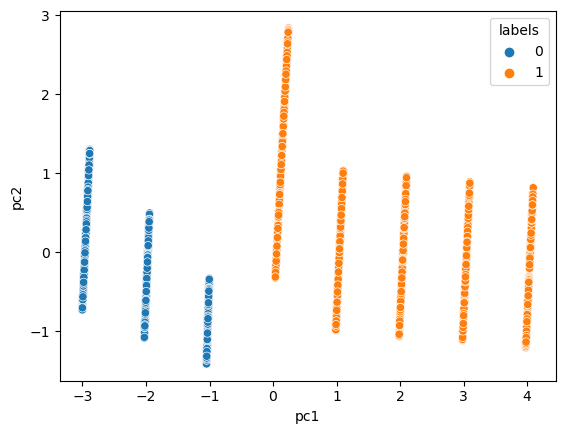

In [40]:
_=sns.scatterplot(x='pc1', y='pc2', hue='labels', data=data2)
# 분포 왜 이럼?

In [41]:
train_copy=pd.concat([train_copy, data2["labels"].to_frame()], axis=1)
train_copy.head()

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type,labels
0,-0.240260,0.272396,0.0,0.227873,0.202708,0.275531,0.164917,0,0
1,0.655844,0.827513,0.0,0.495950,0.821413,0.813992,0.267428,0,0
2,-0.032468,0.402672,0.0,0.290879,0.347863,0.401857,0.191019,0,0
3,0.266234,0.586092,0.0,0.379388,0.552264,0.579576,0.225500,0,0
4,-0.038961,0.400243,0.0,0.289679,0.345324,0.399536,0.191019,0,0


# 6. 훈련 데이터와 검증 데이터를 이용하여 학습하기

In [42]:
X=train_copy.loc[:, :"type"]
y=train_copy[["labels"]]

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=0.2, 
                                                    shuffle=True, 
                                                    random_state=1004,
                                                    stratify=y)

In [44]:
results=[]
i=0
random_state=1000
skf = StratifiedKFold(n_splits=10)
# skf = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
for train_idx, validation_idx in skf.split(X, y):
    x_train_ms = X.iloc[train_idx,:]
    y_train_ms = y.iloc[train_idx]
    x_validation_ms = X.iloc[validation_idx,:]
    y_validation_ms = y.iloc[validation_idx]
    
    # 1. Logistic regression
    model = LogisticRegression(max_iter=1000, random_state=random_state)
    start_time = time.time()
    model.fit(x_train_ms, y_train_ms)
    training_time = time.time() - start_time
    y_pred_train = model.predict(x_train_ms)
    y_pred_validation = model.predict(x_validation_ms)
    accuracy_train = accuracy_score(y_train_ms, y_pred_train)
    accuracy_validation = accuracy_score(y_validation_ms, y_pred_validation)
    results.append([i,'LogisticRegression',accuracy_train,accuracy_validation,training_time])
    
    # 2. Decision tree
    model = DecisionTreeClassifier()
    start_time = time.time()
    model.fit(x_train_ms, y_train_ms)
    training_time = time.time() - start_time
    y_pred_train = model.predict(x_train_ms)
    y_pred_validation = model.predict(x_validation_ms)
    accuracy_train = accuracy_score(y_train_ms, y_pred_train)
    accuracy_validation = accuracy_score(y_validation_ms, y_pred_validation)
    results.append([i,'DecisionTree',accuracy_train,accuracy_validation,training_time])
    
    # 3. Support vector machine
    model = SVC()
    start_time = time.time()
    model.fit(x_train_ms, y_train_ms)
    training_time = time.time() - start_time
    y_pred_train = model.predict(x_train_ms)
    y_pred_validation = model.predict(x_validation_ms)
    accuracy_train = accuracy_score(y_train_ms, y_pred_train)
    accuracy_validation = accuracy_score(y_validation_ms, y_pred_validation)
    results.append([i,'SupportVectorMachine',accuracy_train,accuracy_validation,training_time])
    
    # 4. K nearest neighbor
    model = KNeighborsClassifier()
    start_time = time.time()
    model.fit(x_train_ms, y_train_ms)
    training_time = time.time() - start_time
    y_pred_train = model.predict(x_train_ms)
    y_pred_validation = model.predict(x_validation_ms)
    accuracy_train = accuracy_score(y_train_ms, y_pred_train)
    accuracy_validation = accuracy_score(y_validation_ms, y_pred_validation)
    results.append([i,'KNearestNeighbor',accuracy_train,accuracy_validation,training_time]) 
    
    # 5. SGD
    model = SGDClassifier()
    start_time = time.time()
    model.fit(x_train_ms, y_train_ms)
    training_time = time.time() - start_time
    y_pred_train = model.predict(x_train_ms)
    y_pred_validation = model.predict(x_validation_ms)
    accuracy_train = accuracy_score(y_train_ms, y_pred_train)
    accuracy_validation = accuracy_score(y_validation_ms, y_pred_validation)
    results.append([i,'SGDClassifier',accuracy_train,accuracy_validation,training_time]) 
    i+=1

In [45]:
df_results =pd.DataFrame(data=results, 
                columns= ['iter','method','accuracy_train','accuracy_validation','training_time'])
df_results.tail(20)

,iter,method,accuracy_train,accuracy_validation,training_time
30,6,LogisticRegression,1.0,1.0,0.015618
31,6,DecisionTree,1.0,1.0,0.015621
32,6,SupportVectorMachine,1.0,1.0,0.015624
33,6,KNearestNeighbor,1.0,1.0,0.015626
34,6,SGDClassifier,1.0,1.0,0.000000
35,7,LogisticRegression,1.0,1.0,0.015625
36,7,DecisionTree,1.0,1.0,0.015618
37,7,SupportVectorMachine,1.0,1.0,0.000000
38,7,KNearestNeighbor,1.0,1.0,0.000000
39,7,SGDClassifier,1.0,1.0,0.000000


In [46]:
df_acc_test = df_results.pivot_table(index='method', columns='iter')["accuracy_validation"].reset_index()
df_acc_test['mean']=np.mean(df_acc_test, axis=1)
df_acc_test=df_acc_test.sort_values('mean')
df_acc_test

iter,method,0,1,2,3,4,5,6,7,8,9,mean
0,DecisionTree,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,KNearestNeighbor,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,LogisticRegression,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,SGDClassifier,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,SupportVectorMachine,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


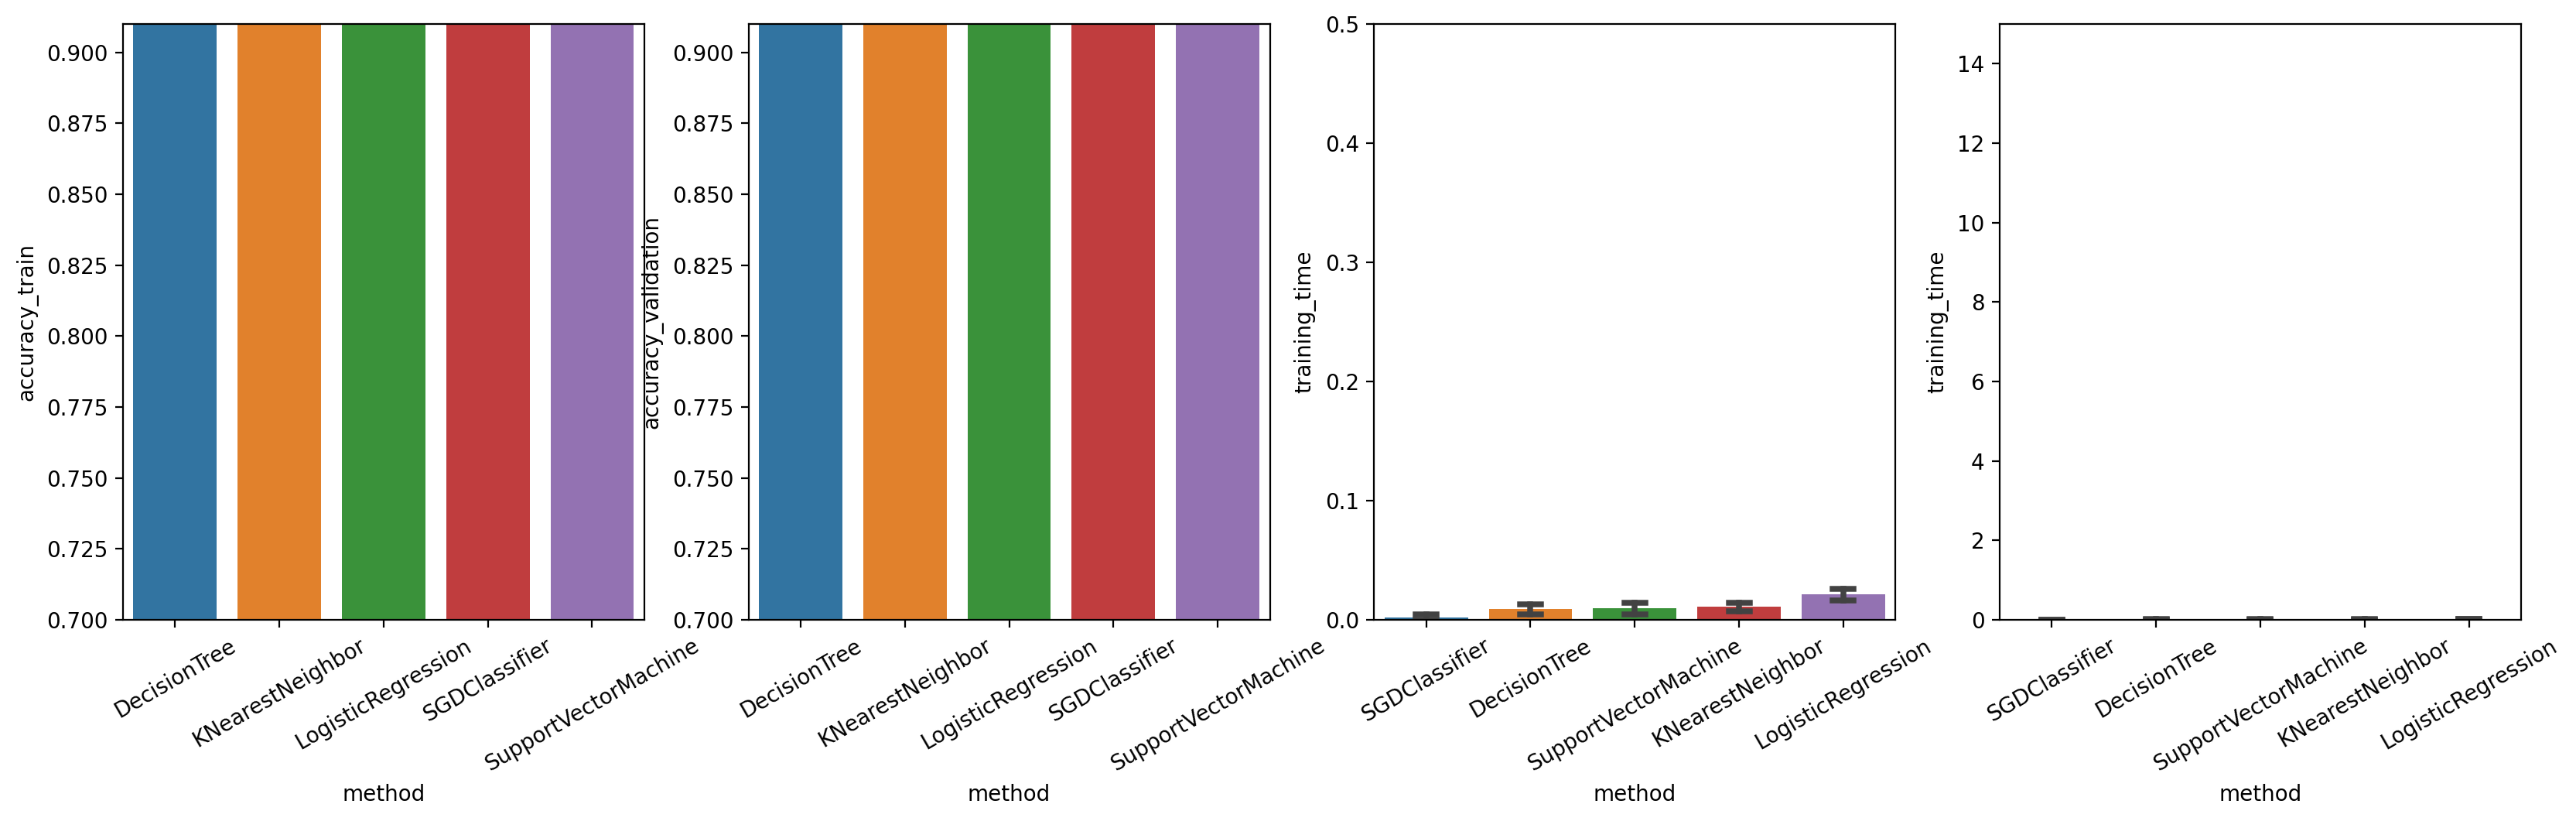

In [47]:
fig, ax=plt.subplots(1, 4, figsize=(20, 5), dpi=200)
ax=ax.flatten()

idx=0
for y_name in ["accuracy_train", "accuracy_validation", "training_time", "training_time"]:
    _=sns.barplot(x="method", y=y_name, data=df_results, capsize=.2, 
                 order=df_results.groupby('method').mean().sort_values(y_name).index, ax=ax[idx])
    _=ax[idx].set(ylim=(0.70, 0.91))
    _=ax[idx].set_xticklabels(ax[idx].get_xticklabels(),rotation=30);
    idx+=1
_=ax[2].set_ylim(0, 0.5) # 0초 ~ 0.5초까지 보여줌.
_=ax[3].set_ylim(0, 15) # 0초 ~ 15초까지 보여줌.

# 최고 성능은 svc 모델을 이용해야 됨